In [ ]:

import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import re

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

def limpiar_tokens(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#|\d+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stopwords.words('spanish') and len(word) > 2]


In [3]:

df = pd.read_csv('../data/data_train.csv')
text_column = "tweet_text" if "tweet_text" in df.columns else df.columns[0]
df['tokens'] = df[text_column].apply(limpiar_tokens)
df['label'] = df['class'].apply(lambda x: 1 if x == 'anorexia' else 0)


In [4]:

modelo_w2v = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
def vectorize(tokens):
    vecs = [modelo_w2v.wv[word] for word in tokens if word in modelo_w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)
df['vector'] = df['tokens'].apply(vectorize)


In [5]:

X = np.vstack(df['vector'].values)
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC(probability=True)
grid = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [15]:
# --- Evaluación ---
from sklearn.metrics import classification_report, roc_auc_score

# Importante: activar probability=True desde el inicio para usar predict_proba
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidad para clase positiva

print("Mejor combinación de hiperparámetros:")
print(grid.best_params_)

print("Mejor AUC en validación cruzada (con accuracy):", grid.best_score_)
print("AUC en test:", roc_auc_score(y_test, y_proba))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["Control", "Anorexia"]))

Mejor combinación de hiperparámetros:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor AUC en validación cruzada (con accuracy): 0.7741666666666666
AUC en test: 0.9031624960970606
Reporte de clasificación:
              precision    recall  f1-score   support

     Control       0.84      0.78      0.81       141
    Anorexia       0.82      0.87      0.84       159

    accuracy                           0.83       300
   macro avg       0.83      0.82      0.83       300
weighted avg       0.83      0.83      0.83       300



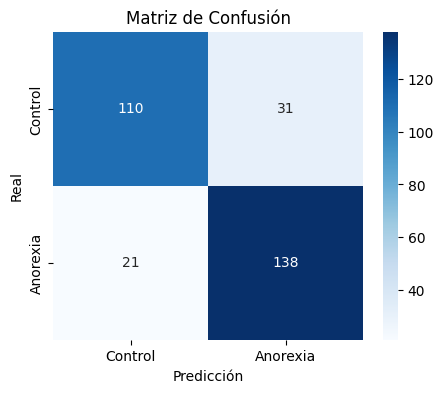

In [16]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Control", "Anorexia"], yticklabels=["Control", "Anorexia"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

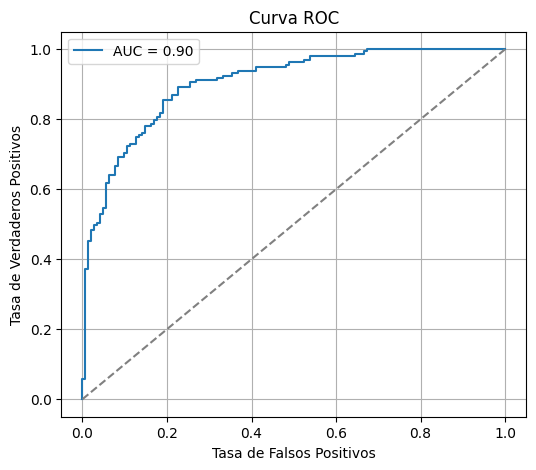

In [17]:
# --- Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()